# xAG予測コンペ　ベースラインコード（その2）

ベースラインコード（host_baseline_001.ipynb）について、特徴量の追加作成やパラメータ最適化を行った改善版コードです。

In [1]:
#第一回はこちら
#https://www.kaggle.com/competitions/dsdojo_1/overview

---
## セットアップ



In [2]:
# 必要モジュールでColab環境にないものはinstall
!pip install japanize_matplotlib


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [3]:
# 必要モジュールをimport
import json
from datetime import datetime
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
import japanize_matplotlib
import lightgbm as lgb
from sklearn.model_selection import train_test_split, KFold, GroupKFold
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# ランダム性を伴う処理を行うため、結果の再現性を保つにはシード値を固定しておく必要があります
SEED = 42
np.random.seed(SEED)

In [4]:
# 表示できるdfの行、列数を増やす
pd.set_option("display.max_rows", 100)    # 最大100行まで表示
pd.set_option("display.max_columns", 100) # 最大100列まで表示

## データ読み込み

In [5]:
# ローカル実行用のパス設定
base_path = '../../data'
print(f"データ読み込み元パス: {base_path}")

# データ読み込み
# player_idやmatch_idの数値的大小に意味はないのでstring形式で読み込み
train_df = pd.read_csv(f"{base_path}/match_train_data.csv", dtype={"player_id": "string", "match_id": "string"})
test_df = pd.read_csv(f"{base_path}/match_test_data.csv", dtype={"player_id": "string", "match_id": "string"})
actions_df = pd.read_csv(f"{base_path}/action_data.csv", dtype={"player_id": "string", "match_id": "string"})
submission_df = pd.read_csv(f"{base_path}/sample_submission.csv")

print(f"trainデータ形状: {train_df.shape}")
display(train_df.head(3))

print(f"\ntestデータ形状: {test_df.shape}")
display(test_df.head(3))

print(f"\nアクションデータ形状: {actions_df.shape}")
display(actions_df.head(3))

データ読み込み元パス: ../../data
trainデータ形状: (27870, 14)


,Date,Day,Comp,Round,Venue,Result,Squad,Opponent,xAG,player_name,birth_date,URL,player_id,match_id
0,2017-09-09,Sat,Premier League,Matchweek 4,Away,W 2–1,Chelsea,Leicester City,0.1,Eden Hazard,1991-01-07,https://fbref.com/en/players/a39bb753/Eden-Hazard,25707,2499753
1,2017-09-17,Sun,Premier League,Matchweek 5,Home,D 0–0,Chelsea,Arsenal,0.0,Eden Hazard,1991-01-07,https://fbref.com/en/players/a39bb753/Eden-Hazard,25707,2499760
2,2017-09-23,Sat,Premier League,Matchweek 6,Away,W 4–0,Chelsea,Stoke City,0.0,Eden Hazard,1991-01-07,https://fbref.com/en/players/a39bb753/Eden-Hazard,25707,2499776



testデータ形状: (12798, 13)


,Date,Day,Comp,Round,Venue,Result,Squad,Opponent,player_name,birth_date,URL,player_id,match_id
0,2018-02-12,Mon,Premier League,Matchweek 27,Home,W 3–0,Chelsea,West Brom,Eden Hazard,1991-01-07,https://fbref.com/en/players/a39bb753/Eden-Hazard,25707,2499979
1,2018-02-25,Sun,Premier League,Matchweek 28,Away,L 1–2,Chelsea,Manchester Utd,Eden Hazard,1991-01-07,https://fbref.com/en/players/a39bb753/Eden-Hazard,25707,2499996
2,2018-03-04,Sun,Premier League,Matchweek 29,Away,L 0–1,Chelsea,Manchester City,Eden Hazard,1991-01-07,https://fbref.com/en/players/a39bb753/Eden-Hazard,25707,2500004



アクションデータ形状: (2303958, 26)


,match_id,match_date,match_venue,match_status,home_team_name,away_team_name,match_winner,period_id,time_seconds,team_id,is_home,player_id,start_x,start_y,end_x,end_y,type_name,result_name,bodypart_name,team_name_short,birth_date,player_name,jersey_number,minutes_played,is_starter,competition
0,2576335,"May 20, 2018 at 8:45:00 PM GMT+2",NaN,Played,SS Lazio,FC Internazionale Milano,3161,1,2.417590,3161,False,3344,53.55,34.00,65.10,39.44,pass,success,foot,Internazionale,1993-02-12,Rafael Alcântara do Nascimento,0,69,True,Italian first division
1,2576335,"May 20, 2018 at 8:45:00 PM GMT+2",NaN,Played,SS Lazio,FC Internazionale Milano,3161,1,3.904412,3161,False,116349,65.10,39.44,66.15,61.88,pass,success,foot,Internazionale,1991-08-24,Matías Vecino Falero,0,96,True,Italian first division
2,2576335,"May 20, 2018 at 8:45:00 PM GMT+2",NaN,Played,SS Lazio,FC Internazionale Milano,3161,1,6.484211,3161,False,135903,66.15,61.88,69.30,48.96,pass,success,foot,Internazionale,1994-05-27,João Pedro Cavaco Cancelo,0,96,True,Italian first division


## 特徴量エンジニアリング - 基本特徴量

まず、001と同じ基本的な特徴量を作成します。

In [6]:
# 所与のデータから簡単に計算できる年齢特徴量を追加する

# 2017/18シーズン終了時点での年齢を計算
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df['birth_date'] = pd.to_datetime(train_df['birth_date'])
train_df['age'] = (train_df['Date'] - train_df['birth_date']).dt.days / 365.25

test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df['birth_date'] = pd.to_datetime(test_df['birth_date'])
test_df['age'] = (test_df['Date'] - test_df['birth_date']).dt.days / 365.25

print(f"\nマージ後のtrainデータ形状: {train_df.shape}")
print(f"\nマージ後のtestデータ形状: {test_df.shape}")


マージ後のtrainデータ形状: (27870, 15)

マージ後のtestデータ形状: (12798, 14)


In [7]:
# アクションデータから試合×選手レベルの特徴量を作成

# train/testに含まれる試合×選手の組み合わせを作成する
target_match_players_train = train_df[['match_id', 'player_id']].drop_duplicates()
target_match_players_test = test_df[['match_id', 'player_id']].drop_duplicates()
target_match_players = pd.concat([target_match_players_train, target_match_players_test]).drop_duplicates()

print(f"分析対象となる試合×選手: {len(target_match_players)}組")

# アクションデータのうち、train/testデータに含まれる試合×選手のアクションのみを抽出
relevant_actions = actions_df.merge(
    target_match_players,
    on=['match_id', 'player_id'],
    how='inner'
)
print(f"抽出されたアクション数: {len(relevant_actions)}件")

分析対象となる試合×選手: 40505組
抽出されたアクション数: 1867094件


In [8]:
# 位置データについては、homeとawayで基準が異なる
# homeの場合は、x=0が自陣ゴールライン、x=105が敵陣ゴールライン、y=0が右サイドライン、y=68が左サイドラインに対応する
# awayでは逆になるため、homeの選手とawayの選手で平均的なx,yの値を比較することができない
display(relevant_actions[(relevant_actions["type_name"] == "shot") & (relevant_actions["result_name"] == "success")][["is_home", "start_x", "start_y", "end_x", "end_y"]].head())

# そこで、位置を標準化するため、awayチームの場合は、x' = 105-x, y' = 68-yに修正する
relevant_actions.loc[relevant_actions['is_home'] == False, 'start_x'] = 105 - relevant_actions.loc[relevant_actions['is_home'] == False, 'start_x']
relevant_actions.loc[relevant_actions['is_home'] == False, 'end_x'] = 105 - relevant_actions.loc[relevant_actions['is_home'] == False, 'end_x']
relevant_actions.loc[relevant_actions['is_home'] == False, 'start_y'] = 68 - relevant_actions.loc[relevant_actions['is_home'] == False, 'start_y']
relevant_actions.loc[relevant_actions['is_home'] == False, 'end_y'] = 68 - relevant_actions.loc[relevant_actions['is_home'] == False, 'end_y']

relevant_actions[(relevant_actions["type_name"] == "shot") & (relevant_actions["result_name"] == "success")][["is_home", "start_x", "start_y", "end_x", "end_y"]].head()

,is_home,start_x,start_y,end_x,end_y
328,False,1.05,34.68,0.0,37.4
448,True,87.15,33.32,105.0,37.4
905,False,8.40,40.12,0.0,30.6
3296,True,100.80,29.92,105.0,30.6
4080,True,95.55,34.68,105.0,34.0


,is_home,start_x,start_y,end_x,end_y
328,False,103.95,33.32,105.0,30.6
448,True,87.15,33.32,105.0,37.4
905,False,96.60,27.88,105.0,37.4
3296,True,100.80,29.92,105.0,30.6
4080,True,95.55,34.68,105.0,34.0


is_homeの値に関係なく、ゴールした場合end_x=105となっており、位置が標準化されている

In [9]:
# 基本的な統計特徴量の作成
# groupby()とagg()を組み合わせることで、列ごとに任意の集計方法を指定できる。
match_player_stats = (
    relevant_actions
    .groupby(['match_id', 'player_id'])
    .agg(
        action_count   = ('type_name', 'size'), # アクション数合計
        avg_x          = ('start_x', 'mean'), # 平均ポジション（前後方向）
        avg_y          = ('start_y', 'mean'), # 平均ポジション（左右方向）
        minutes_played = ('minutes_played', 'first')  # 出場時間
    )
    .round(2)
    .reset_index()
)

print(f"作成したデータ形状: {match_player_stats.shape}")
display(match_player_stats.head(3))

作成したデータ形状: (40041, 6)


,match_id,player_id,action_count,avg_x,avg_y,minutes_played
0,2499719,120339,80,53.84,30.40,70
1,2499719,12829,16,77.44,43.05,98
2,2499719,14763,30,67.24,35.36,75


In [10]:
# ゴール数の集計
# type_nameにshotが含まれて、成功したアクションはゴールになる
is_shot  = relevant_actions['type_name'].isin(['shot', 'shot_freekick', 'shot_penalty'])
is_success = relevant_actions['result_name'].eq('success')
is_goal = (is_shot & is_success).astype(int)

match_player_goals = (
    relevant_actions
    .assign(is_goal=is_goal) # is_goal列を追加
    .groupby(['match_id', 'player_id'], as_index=False)['is_goal']
    .sum() # ゴールであるアクションを合計
    .rename(columns={'is_goal': 'goal_count'})
)

print(f"作成したデータ形状: {match_player_goals.shape}")
display(match_player_goals.head(3))

作成したデータ形状: (40041, 3)


,match_id,player_id,goal_count
0,2499719,120339,0
1,2499719,12829,2
2,2499719,14763,1


In [11]:
# アクションタイプ数の集計
# type_name列の値ごとに数を集計する
action_type_stats = (
    relevant_actions
    .groupby(['match_id', 'player_id', 'type_name'])
    .size()
    .unstack(fill_value=0)  # type_name を列に展開、欠損は0で埋める
    .rename_axis(None, axis=1)
    .add_prefix('type_').add_suffix('_count') # 列名に接頭辞と接尾辞を追加する（type_nameがshotなら「type_shot_count」になる）
    .reset_index()
)

print(f"作成したデータ形状: {action_type_stats.shape}")
display(action_type_stats.head(3))

作成したデータ形状: (40041, 21)


,match_id,player_id,type_bad_touch_count,type_clearance_count,type_corner_crossed_count,type_corner_short_count,type_cross_count,type_dribble_count,type_foul_count,type_freekick_crossed_count,type_freekick_short_count,type_goalkick_count,type_interception_count,type_keeper_save_count,type_pass_count,type_shot_count,type_shot_freekick_count,type_shot_penalty_count,type_tackle_count,type_take_on_count,type_throw_in_count
0,2499719,120339,0,2,0,0,2,4,0,0,0,0,5,0,66,1,0,0,0,0,0
1,2499719,12829,0,0,0,0,1,2,0,0,0,0,0,0,11,2,0,0,0,0,0
2,2499719,14763,0,0,0,0,1,5,3,0,0,0,0,0,17,2,0,0,1,1,0


In [12]:
# ここまでに作成した特徴量をマージする
train_df = (
    train_df
    .merge(match_player_stats, on=['match_id', 'player_id'], how='left')
    .merge(match_player_goals, on=['match_id', 'player_id'], how='left')
    .merge(action_type_stats, on=['match_id', 'player_id'], how='left')
)

test_df = (
    test_df
    .merge(match_player_stats, on=['match_id', 'player_id'], how='left')
    .merge(match_player_goals, on=['match_id', 'player_id'], how='left')
    .merge(action_type_stats, on=['match_id', 'player_id'], how='left')
)


# マージで生じた欠損値を0で埋める
action_type_cols = [col for col in train_df.columns if col.startswith('type_')]
stats_count_cols = ['action_count', 'minutes_played', 'goal_count'] # avg_x, avg_yは0埋めすると誤った情報になるため、欠損のまま残す

for col in action_type_cols + stats_count_cols:
    if col in train_df.columns:
        train_df[col] = train_df[col].fillna(0)
    if col in test_df.columns:
        test_df[col] = test_df[col].fillna(0)


print(f"\nマージ後のtrainデータshape: {train_df.shape}")
print(f"\nマージ後のtestデータshape: {test_df.shape}")


マージ後のtrainデータshape: (27870, 39)

マージ後のtestデータshape: (12798, 38)


## 特徴量エンジニアリング - 応用特徴量

ここから、より高度な特徴量を作成していきます。各特徴量の意図と計算方法を詳しく説明します。

In [13]:
# アクション成功率特徴量
# アシストに繋がる可能性を評価するため、各種アクションの成功率を計算する

# 成功率を計算するアクションタイプ
action_types_with_result = ['pass', 'shot', 'take_on', 'cross', 'corner_crossed', 'freekick_crossed']  # take_onはドリブルでの仕掛け

success_rates_list = []
print("アクション成功率特徴量を計算中...")

for (match_id, player_id), group in tqdm(relevant_actions.groupby(['match_id', 'player_id']), desc="Calculating success rates"):
    row_data = {'match_id': match_id, 'player_id': player_id}

    for action_type in action_types_with_result:
        type_actions = group[group['type_name'] == action_type] # 対象アクションを抽出

        if len(type_actions) > 0:
            success_count = len(type_actions[type_actions['result_name'] == 'success'])
            total_count = len(type_actions)

            # 成功率を計算
            success_rate = success_count / total_count
            row_data[f'{action_type}_success_rate'] = success_rate
        else:
            # 該当アクションがない場合は0
            row_data[f'{action_type}_success_rate'] = 0

    success_rates_list.append(row_data)

success_rates = pd.DataFrame(success_rates_list)

print(f"作成したデータ形状: {success_rates.shape}")
display(success_rates.head(3))

アクション成功率特徴量を計算中...


Calculating success rates:   0%|          | 0/40041 [00:00<?, ?it/s]

作成したデータ形状: (40041, 8)


,match_id,player_id,pass_success_rate,shot_success_rate,take_on_success_rate,cross_success_rate,corner_crossed_success_rate,freekick_crossed_success_rate
0,2499719,120339,0.924242,0.0,0.0,1.0,0.0,0.0
1,2499719,12829,0.636364,1.0,0.0,0.0,0.0,0.0
2,2499719,14763,0.647059,0.5,1.0,0.0,0.0,0.0


In [14]:
# 位置ベース特徴量
# フィールド上での活動エリアを分析し、攻撃的な選手を識別

print("位置ベース特徴量を計算中...")

# フィールドを3つのエリアに分割（x座標ベース）
def categorize_position(x):
    """x座標からフィールドエリアを判定"""
    if x < 35:
        return 'defensive'  # 守備的エリア
    elif x < 70:
        return 'midfield'   # 中盤エリア
    else:
        return 'attacking'  # 攻撃的エリア

# 各アクションのエリアを判定
relevant_actions['start_zone'] = relevant_actions['start_x'].apply(categorize_position)

# ゾーン別アクション数を集計
zone_actions = (
    relevant_actions
    .pivot_table(
        index=['match_id', 'player_id'],
        columns='start_zone',
        values='period_id',
        aggfunc='count',
        fill_value=0
    )
    .add_prefix('zone_')
    .add_suffix('_actions')
    .reset_index()
)

# 各ゾーンでのアクション比率を計算
zone_actions['total_actions'] = (
    zone_actions.get('zone_defensive_actions', 0) +
    zone_actions.get('zone_midfield_actions', 0) +
    zone_actions.get('zone_attacking_actions', 0)
)

zone_actions['zone_attacking_actions_ratio'] = np.where(
    zone_actions['total_actions'] > 0,
    zone_actions.get('zone_attacking_actions', 0) / zone_actions['total_actions'],
    0
)

zone_actions['zone_midfield_actions_ratio'] = np.where(
    zone_actions['total_actions'] > 0,
    zone_actions.get('zone_midfield_actions', 0) / zone_actions['total_actions'],
    0
)

zone_actions['zone_defensive_actions_ratio'] = np.where(
    zone_actions['total_actions'] > 0,
    zone_actions.get('zone_defensive_actions', 0) / zone_actions['total_actions'],
    0
)
zone_actions = zone_actions.drop(columns=['total_actions'])

print(f"\nゾーン別アクション統計:")
for zone in ['defensive', 'midfield', 'attacking']:
    col_name = f'zone_{zone}_actions'
    if col_name in zone_actions.columns:
        mean_val = zone_actions[col_name].mean()
        print(f"  {zone:10s}エリア: 平均 {mean_val:.1f} アクション")

print(f"\n作成したデータ形状: {zone_actions.shape}")
display(zone_actions.head(3))

位置ベース特徴量を計算中...

ゾーン別アクション統計:
  defensive エリア: 平均 13.5 アクション
  midfield  エリア: 平均 20.8 アクション
  attacking エリア: 平均 12.3 アクション

作成したデータ形状: (40041, 8)


start_zone,match_id,player_id,zone_attacking_actions,zone_defensive_actions,zone_midfield_actions,zone_attacking_actions_ratio,zone_midfield_actions_ratio,zone_defensive_actions_ratio
0,2499719,120339,19,16,45,0.2375,0.562500,0.200000
1,2499719,12829,12,0,4,0.7500,0.250000,0.000000
2,2499719,14763,15,5,10,0.5000,0.333333,0.166667


In [15]:
# 時間正規化特徴量
# 出場時間による影響を排除し、公平な比較を可能にする

print("時間正規化特徴量を計算中...")

per_minute_features = match_player_stats.copy()

# 全体アクション数の正規化
per_minute_features['action_count_per_minute'] = np.where(
    per_minute_features['minutes_played'] > 0,
    per_minute_features['action_count'] / per_minute_features['minutes_played'],
    0
)

# ゴール数をマージ・ゼロ埋め
per_minute_features = per_minute_features.merge(
    match_player_goals,
    on=['match_id', 'player_id'],
    how='left'
)
per_minute_features['goal_count'] = per_minute_features['goal_count'].fillna(0)

# ゴール数の正規化
per_minute_features['goal_count_per_minute'] = np.where(
    per_minute_features['minutes_played'] > 0,
    per_minute_features['goal_count'] / per_minute_features['minutes_played'],
    0
)

# アクションタイプ別アクション数をマージ・ゼロ埋め
per_minute_features = per_minute_features.merge(
    action_type_stats,
    on=['match_id', 'player_id'],
    how='left'
)
action_type_cols = [col for col in per_minute_features.columns if col.startswith('type_') and col.endswith('_count')] # アクションタイプ別アクション数の列
for col in action_type_cols:
    per_minute_features[col] = per_minute_features[col].fillna(0)

# アクションタイプ別アクション数の正規化
for col in action_type_cols:
    new_col_name = col.replace('_count', '_count_per_minute')
    per_minute_features[new_col_name] = np.where(
        per_minute_features['minutes_played'] > 0,
        per_minute_features[col] / per_minute_features['minutes_played'],
        0
    )

# 新規作成した列のみに絞り込み
per_minute_cols = [col for col in per_minute_features.columns if col.endswith('_per_minute')]
per_minute_features = per_minute_features[['match_id', 'player_id'] + per_minute_cols]

print(f"\n作成したデータ形状: {per_minute_features.shape}")
display(per_minute_features.head(3))

時間正規化特徴量を計算中...

作成したデータ形状: (40041, 23)


,match_id,player_id,action_count_per_minute,goal_count_per_minute,type_bad_touch_count_per_minute,type_clearance_count_per_minute,type_corner_crossed_count_per_minute,type_corner_short_count_per_minute,type_cross_count_per_minute,type_dribble_count_per_minute,type_foul_count_per_minute,type_freekick_crossed_count_per_minute,type_freekick_short_count_per_minute,type_goalkick_count_per_minute,type_interception_count_per_minute,type_keeper_save_count_per_minute,type_pass_count_per_minute,type_shot_count_per_minute,type_shot_freekick_count_per_minute,type_shot_penalty_count_per_minute,type_tackle_count_per_minute,type_take_on_count_per_minute,type_throw_in_count_per_minute
0,2499719,120339,1.142857,0.000000,0.0,0.028571,0.0,0.0,0.028571,0.057143,0.00,0.0,0.0,0.0,0.071429,0.0,0.942857,0.014286,0.0,0.0,0.000000,0.000000,0.0
1,2499719,12829,0.163265,0.020408,0.0,0.000000,0.0,0.0,0.010204,0.020408,0.00,0.0,0.0,0.0,0.000000,0.0,0.112245,0.020408,0.0,0.0,0.000000,0.000000,0.0
2,2499719,14763,0.400000,0.013333,0.0,0.000000,0.0,0.0,0.013333,0.066667,0.04,0.0,0.0,0.0,0.000000,0.0,0.226667,0.026667,0.0,0.0,0.013333,0.013333,0.0


In [16]:
# 攻撃/守備バランス特徴量
# 選手のプレースタイルを定量化し、攻撃的な選手を識別

print("攻撃/守備バランス特徴量を計算中...")

# 攻撃/守備アクションの定義
offensive_actions = ['shot', 'pass', 'cross', 'take_on', 'dribble']
defensive_actions = ['tackle', 'interception', 'clearance']

# 各アクションの分類を付与
def categorize_ad(action):
    if action in offensive_actions:
        return 'offensive'
    elif action in defensive_actions:
        return 'defensive'
    else:
        return None

relevant_actions['action_type'] = relevant_actions['type_name'].apply(categorize_ad)

# 攻守別アクション数を集計
offense_defense_balance = (
    relevant_actions
    .pivot_table(
        index=['match_id', 'player_id'],
        columns='action_type',
        values='period_id',
        aggfunc='count',
        fill_value=0
    )
    .add_prefix('type_')
    .add_suffix('_actions')
    .reset_index()
)

# 攻守バランス指標を計算
offense_defense_balance['total_actions'] = (
    offense_defense_balance.get('type_offensive_actions', 0) +
    offense_defense_balance.get('type_defensive_actions', 0)
)

offense_defense_balance['type_offensive_action_ratio'] = np.where(
    offense_defense_balance['total_actions'] > 0,
    offense_defense_balance['type_offensive_actions'] / offense_defense_balance['total_actions'],
    0
)

offense_defense_balance = offense_defense_balance.drop(columns=['total_actions'])

print(f"\n作成したデータ形状: {offense_defense_balance.shape}")
display(offense_defense_balance.head(3))

攻撃/守備バランス特徴量を計算中...

作成したデータ形状: (40010, 5)


action_type,match_id,player_id,type_defensive_actions,type_offensive_actions,type_offensive_action_ratio
0,2499719,120339,7,73,0.912500
1,2499719,12829,0,16,1.000000
2,2499719,14763,1,26,0.962963


In [17]:
# 時系列要素を加味した特徴量
# xAGの定義を考えると、パスした味方のシュートが多いほどxAGは高くなる
# そこで、次アクションがシュートであるパスの数を選手-試合ごとに集計する

print("次アクションがシュートのパス数を計算中...")

# 直後のアクションタイプをシフトで付与
relevant_actions = relevant_actions.sort_values(['match_id', 'period_id', 'time_seconds'])  # 念の為アクションを時間でソート
relevant_actions["next_type"] = relevant_actions.groupby("match_id")["type_name"].shift(-1)

# pass → shot となっている行を抽出
pass_to_shot = relevant_actions[
    (relevant_actions["type_name"] == "pass") &
    (relevant_actions["next_type"] == "shot")
]

# match_id, player_idごとにカウント
pass_leads_to_shot = (
    pass_to_shot.groupby(["match_id", "player_id"])
    .size()
    .reset_index(name="pass_leads_to_shot")
)

print(f"\n作成したデータ形状: {pass_leads_to_shot.shape}")
display(pass_leads_to_shot.head(3))

次アクションがシュートのパス数を計算中...

作成したデータ形状: (13176, 3)


,match_id,player_id,pass_leads_to_shot
0,2499719,120339,1
1,2499719,14869,1
2,2499719,167145,2


さらに深掘りする価値がありそうな取り組み案
- パスとその後のアクションの時系列に関する特徴量追加
    - アクション間の時間とかも重要かも
- パスのstart→endの長さやシュートの距離についての特徴量追加
- 試合x選手単位でなく、選手単位での集計（1試合だけだと調子の波もあるので、通年で見るほうが選手特性は把握しやすいかも）
- などなど

## 特徴量の統合

作成した全ての特徴量を統合し、train/testデータにマージします。

In [18]:
# ここまでに作成した特徴量をマージする
train_df = (
    train_df
    .merge(success_rates, on=['match_id', 'player_id'], how='left')
    .merge(zone_actions, on=['match_id', 'player_id'], how='left')
    .merge(per_minute_features, on=['match_id', 'player_id'], how='left')
    .merge(offense_defense_balance, on=['match_id', 'player_id'], how='left')
    .merge(pass_leads_to_shot, on=['match_id', 'player_id'], how='left')
)

test_df = (
    test_df
    .merge(success_rates, on=['match_id', 'player_id'], how='left')
    .merge(zone_actions, on=['match_id', 'player_id'], how='left')
    .merge(per_minute_features, on=['match_id', 'player_id'], how='left')
    .merge(offense_defense_balance, on=['match_id', 'player_id'], how='left')
    .merge(pass_leads_to_shot, on=['match_id', 'player_id'], how='left')
)

print(f"\nマージ後のtrainデータshape: {train_df.shape}")
print(f"\nマージ後のtestデータshape: {test_df.shape}")


マージ後のtrainデータshape: (27870, 76)

マージ後のtestデータshape: (12798, 75)


## クロスバリデーション分割

初回のbaselineでは、全データをランダムに分割するKFoldを用いましたが、今回はデータ特性に合わせた別の分割方法を行います。

EDAで確認したように、今回はtrainデータとtestデータについては、match_idの重なりはありません。
すなわち、testデータを予測するときには、これまで見たことのない試合のデータに対して予測をする必要があります。
この状況をtrainデータ内部でのCross Validationでもなるべく再現することによって、実際のタスクに近い状況で正しい評価が可能になります。

ここでは、GroupKFoldを用いて、trainデータをmatch_idが被らないように5分割します。こうすることで、各foldでのtrainデータとvalidデータのmatch_idが重ならなくなります。


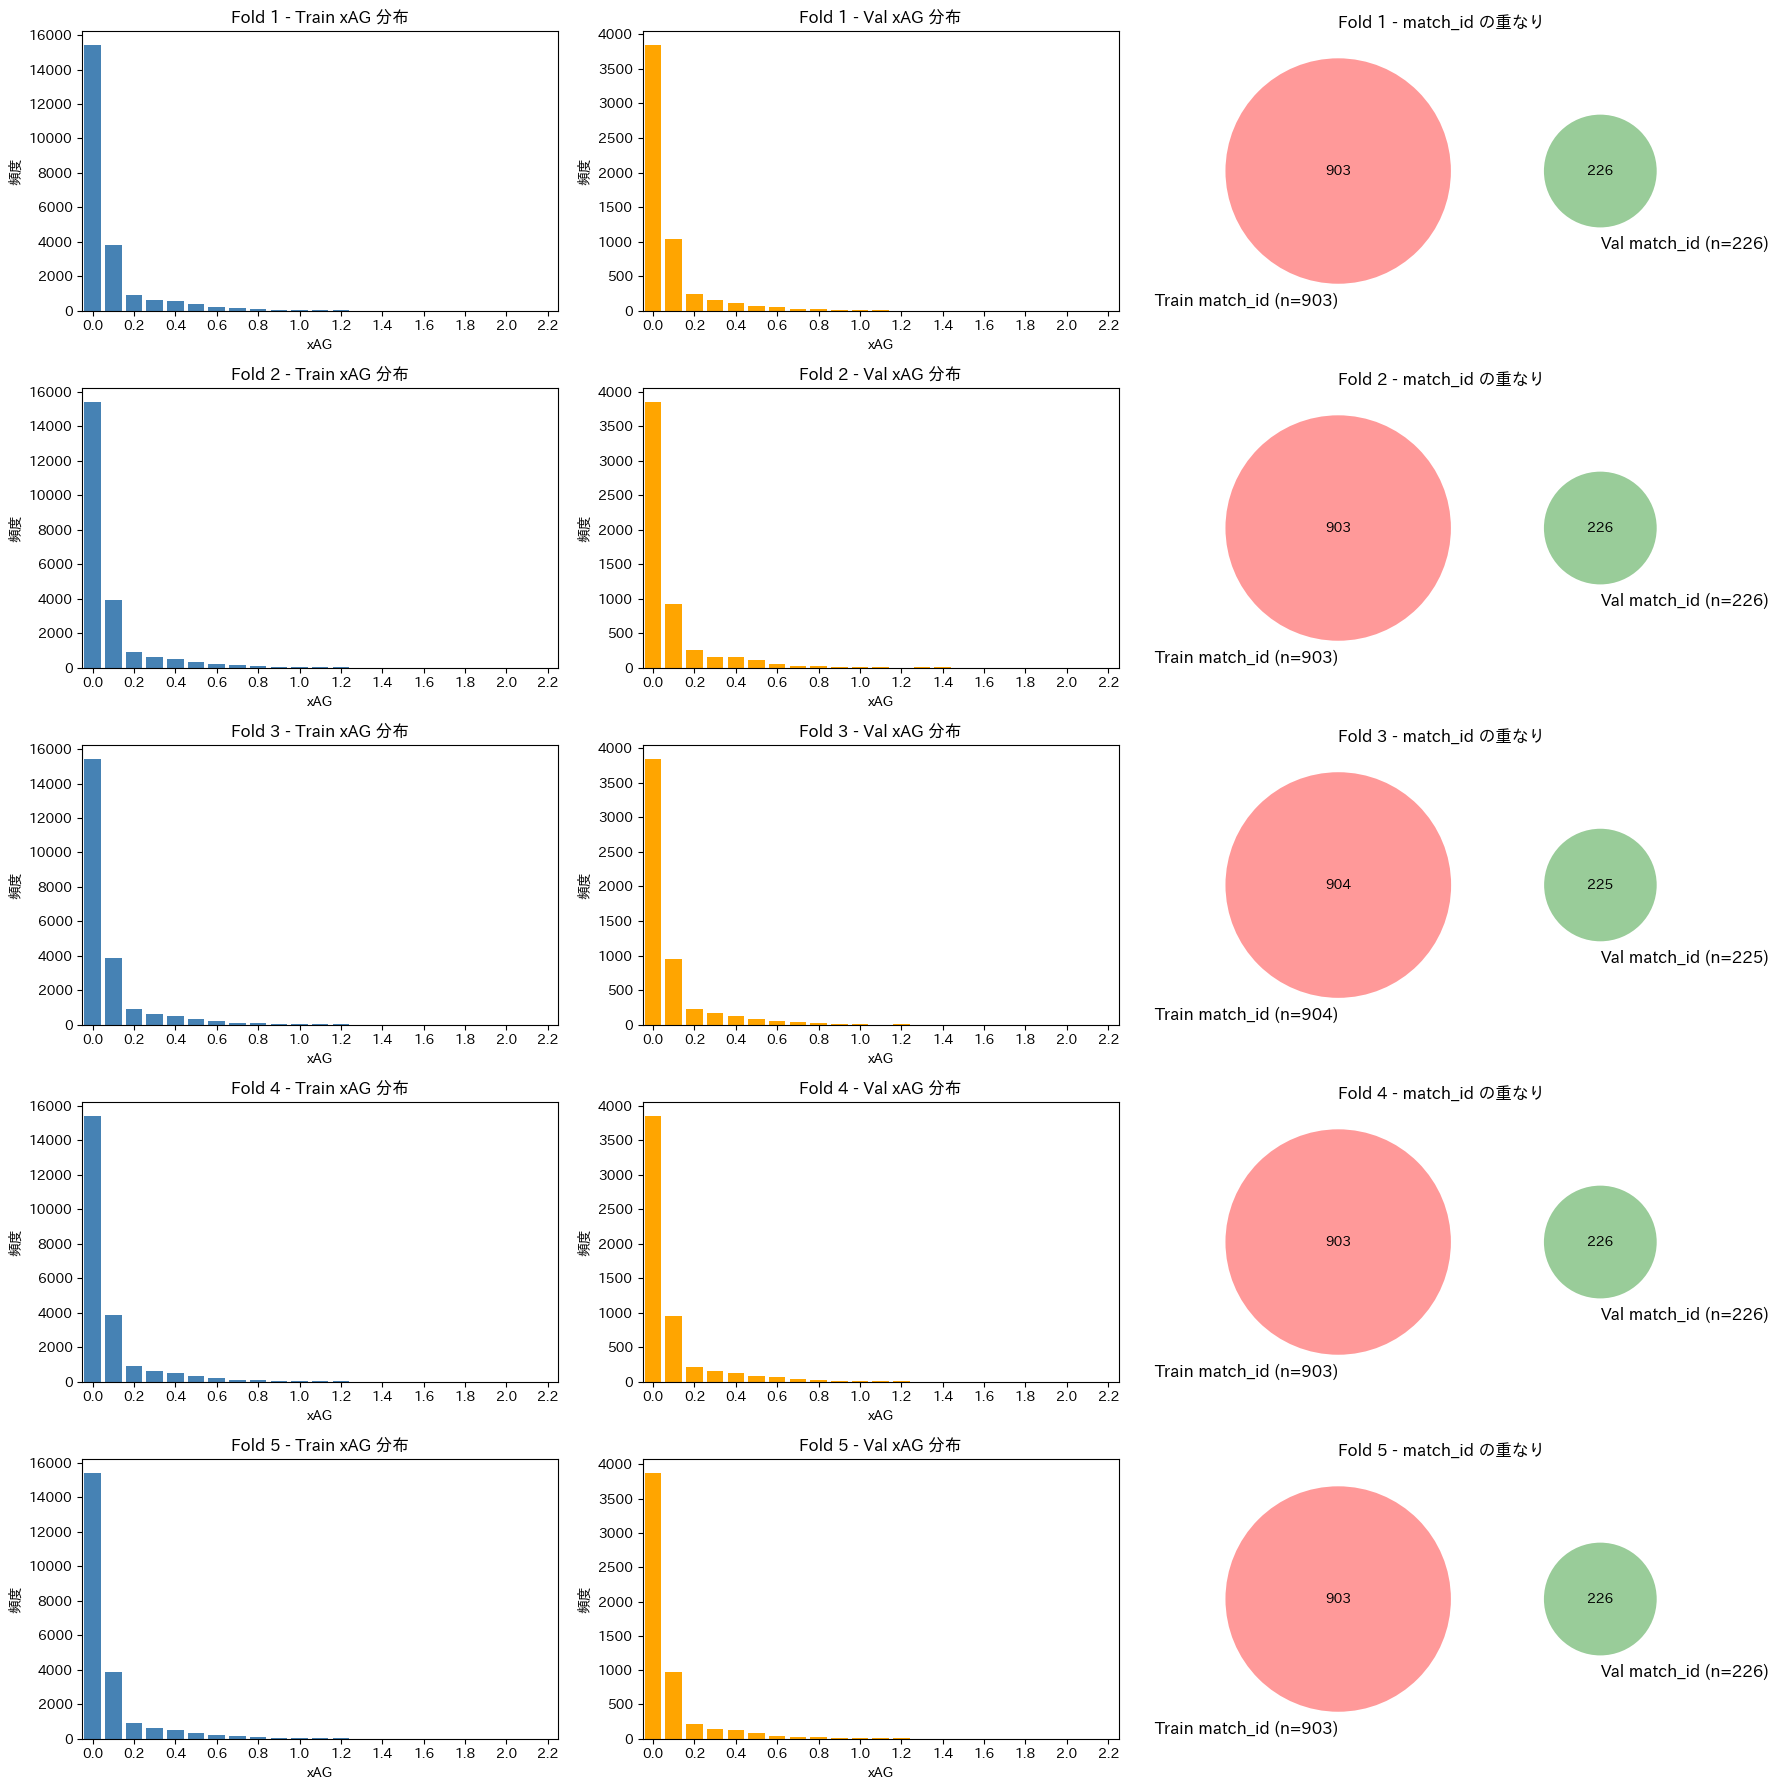

In [19]:
# 5分割のGroupKFoldを設定（match_idでグループ化）
gkf = GroupKFold(n_splits=5)
train_df["fold"] = 0  # 0で初期化

# xAG軸のスケールは共通化して見やすくする
x_min, x_max = train_df["xAG"].min(), train_df["xAG"].max()
xAG_vals = np.arange(x_min, x_max + 0.1, 0.1).round(1)

# 図: 各foldごとに 3カラム（Train分布, Val分布, match_idベン図）
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 18), sharey=False, sharex=False)

for i, (trn_idx, val_idx) in enumerate(gkf.split(train_df, groups=train_df["match_id"])):
    # fold列をセット
    train_df.loc[val_idx, "fold"] = i + 1

    # train/val の xAG 分布を取得（共通スケールにリインデックス）
    trn_counts = (
        train_df.iloc[trn_idx]["xAG"].value_counts().sort_index()
        .reindex(xAG_vals, fill_value=0)
    )
    val_counts = (
        train_df.iloc[val_idx]["xAG"].value_counts().sort_index()
        .reindex(xAG_vals, fill_value=0)
    )

    # 左列: 各foldのtrainデータ分布
    ax_train = axes[i, 0]
    ax_train.bar(trn_counts.index, trn_counts.values, width=0.08, color="steelblue")
    ax_train.set_title(f"Fold {i+1} - Train xAG 分布")
    ax_train.set_xlabel("xAG")
    ax_train.set_ylabel("頻度")

    # 中列: 各foldのvalidationデータ分布
    ax_val = axes[i, 1]
    ax_val.bar(val_counts.index, val_counts.values, width=0.08, color="orange")
    ax_val.set_title(f"Fold {i+1} - Val xAG 分布")
    ax_val.set_xlabel("xAG")
    ax_val.set_ylabel("頻度")

    # 右列: match_idのベン図（Train vs Val）
    ax_venn = axes[i, 2]
    trn_match_ids = set(train_df.iloc[trn_idx]["match_id"])
    val_match_ids = set(train_df.iloc[val_idx]["match_id"])
    v = venn2(
        [trn_match_ids, val_match_ids],
        set_labels=(f"Train match_id (n={len(trn_match_ids)})",
                    f"Val match_id (n={len(val_match_ids)})"),
        ax=ax_venn
    )
    ax_venn.set_title(f"Fold {i+1} - match_id の重なり")

# x軸を共通スケールに揃える（分布図の2カラムに適用）
for i in range(5):
    for j in [0, 1]:
        ax = axes[i, j]
        ax.set_xlim(x_min - 0.05, x_max + 0.05)  # 端を少し余裕持たせる
        ax.set_xticks(xAG_vals[::2])  # ラベルの数を間引き

plt.tight_layout()
plt.show()

## モデル学習用データ準備

In [20]:
# ターゲットエンコーディング特徴量の作成
print("ターゲットエンコーディング特徴量を作成中...")

target_encoding_cols = ["player_id", "Squad", "Opponent"]
global_mean = train_df["xAG"].mean()
smoothing = 10.0
fold_labels = sorted(train_df["fold"].unique())

for col in target_encoding_cols:
    enc_col = f"{col}_target_enc"
    train_df[enc_col] = np.nan

    for fold in fold_labels:
        trn = train_df[train_df["fold"] != fold]
        val_mask = train_df["fold"] == fold

        stats = trn.groupby(col)["xAG"].agg(["sum", "count"])
        stats["encoding"] = (stats["sum"] + global_mean * smoothing) / (stats["count"] + smoothing)

        train_df.loc[val_mask, enc_col] = train_df.loc[val_mask, col].map(stats["encoding"]).fillna(global_mean)

    overall_stats = train_df.groupby(col)["xAG"].agg(["sum", "count"])
    overall_stats["encoding"] = (overall_stats["sum"] + global_mean * smoothing) / (overall_stats["count"] + smoothing)

    test_df[enc_col] = test_df[col].map(overall_stats["encoding"]).fillna(global_mean)

    missing_train = train_df[enc_col].isna().sum()
    missing_test = test_df[enc_col].isna().sum()

    if missing_train > 0:
        train_df.loc[train_df[enc_col].isna(), enc_col] = global_mean
    if missing_test > 0:
        test_df.loc[test_df[enc_col].isna(), enc_col] = global_mean

    print(f"  {col}: train missing {int(missing_train)}, test missing {int(missing_test)}")

ターゲットエンコーディング特徴量を作成中...
  player_id: train missing 0, test missing 0
  Squad: train missing 0, test missing 0
  Opponent: train missing 0, test missing 0


In [21]:
# 各特徴量グループの定義
base_features = ["age", "action_count", "avg_x", "avg_y", "minutes_played", "goal_count"]
categorical_features = ["Comp", "Squad", "Venue"]
action_type_features = [col for col in train_df.columns if (col.startswith('type_')) and (col.endswith('_count'))]
success_rate_features = [col for col in train_df.columns if col.endswith('_success_rate')]
zone_features = [col for col in train_df.columns if col.startswith('zone_')]
per_minute_features = [col for col in train_df.columns if col.endswith('_per_minute')]
ad_balance_features = ['type_offensive_actions', 'type_defensive_actions', 'type_offensive_action_ratio']
sequencial_features = ['pass_leads_to_shot']
target_encoding_features = [f"{col}_target_enc" for col in ["player_id", "Squad", "Opponent"]]

all_features = (
    base_features
    + categorical_features
    + action_type_features
    + success_rate_features
    + zone_features
    + per_minute_features
    + ad_balance_features
    + sequencial_features
    + target_encoding_features
)

# カテゴリカル変数については、列の型を「category」に変更しておく
for col in categorical_features:
    train_df[col] = train_df[col].astype("category")
    test_df[col] = test_df[col].astype("category")


print(f"  - 使用する特徴量数: {len(all_features)}個")
print(f"  - 基本特徴量: {len(base_features)}個")
print(f"  - カテゴリカル特徴量: {len(categorical_features)}個")
print(f"  - アクション特徴量(type_*_count): {len(action_type_features)}個")
print(f"  - 成功率系: {len(success_rate_features)}個")
print(f"  - ゾーン系: {len(zone_features)}個")
print(f"  - per_minute系: {len(per_minute_features)}個")
print(f"  - 攻守バランス系: {len(ad_balance_features)}個")
print(f"  - 時系列系: {len(sequencial_features)}個")
print(f"  - ターゲットエンコーディング系: {len(target_encoding_features)}個")

  - 使用する特徴量数: 68個
  - 基本特徴量: 6個
  - カテゴリカル特徴量: 3個
  - アクション特徴量(type_*_count): 19個
  - 成功率系: 6個
  - ゾーン系: 6個
  - per_minute系: 21個
  - 攻守バランス系: 3個
  - 時系列系: 1個
  - ターゲットエンコーディング系: 3個


In [22]:
# モデル学習用データの作成
X_train = train_df[all_features + ["fold"]]
y_train = train_df["xAG"]
X_test = test_df[all_features]

print(f"\nモデル学習用データ形状: X_train {X_train.shape}, y_train {y_train.shape}, X_test {X_test.shape}")


モデル学習用データ形状: X_train (27870, 69), y_train (27870,), X_test (12798, 68)


## モデル学習（LightGBM）

In [23]:
# コンペの評価指標に合わせた目的関数/評価関数の定義
def weighted_rmse(y_true, y_pred):
    """
    重み付きRMSE評価関数
    コンペの評価指標に合わせて実装
    """
    w_pos = 5.0
    thresh = 0.1

    # Calculate weighted squared errors
    weights = np.where(y_true >= thresh, w_pos, 1.0)
    squared_errors = (y_true - y_pred) ** 2
    weighted_squared_errors = weights * squared_errors

    # Calculate weighted RMSE with small epsilon for numerical stability
    pw_rmse = np.sqrt(np.mean(weighted_squared_errors) + 1e-9)

    return float(pw_rmse)

def weighted_rmse_feval(y_pred, dtrain):
    """
    LightGBM用の重み付きRMSE評価関数
    """
    y_true = dtrain.get_label()
    weighted_rmse_value = weighted_rmse(y_true, y_pred)
    return "weighted_rmse", weighted_rmse_value, False

def weighted_rmse_obj(y_pred, dtrain):
    """
    LightGBM用の重み付きRMSE目的関数
    """
    w_pos = 5.0
    thresh = 0.1

    y_true = dtrain.get_label()
    weights = np.where(y_true >= thresh, w_pos, 1.0)

    # 勾配とヘッセ行列の計算
    grad = -2 * weights * (y_true - y_pred)
    hess = 2 * weights

    return grad, hess

特徴量の数も増えており、ハイパーパラメータは探索してみないと分かりません。

ここでは、より効率的に良さそうなパラメータを見つけられるOptunaを用いて最適化を行います。
Optunaは探索空間から試行回数ごとに候補を提案し、良かった試行の情報を活かしながら次の探索に反映させるベイズ的最適化アルゴリズム（TPEサンプラー）を利用できるため、総当たりのGridSearchよりも少ない試行で良い結果に辿り着きやすいのがメリットです。
（参考: https://zenn.dev/robes/articles/d53ff6d665650f ）

In [24]:
import optuna
from optuna.samplers import TPESampler

# Optunaで最適化しないベースパラメータ
base_params = {
    "objective": weighted_rmse_obj,
    "boosting_type": "gbdt",
    "random_state": SEED,
    "verbosity": -1,
    "force_col_wise": True,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "feature_fraction": 0.8,
}

# Optunaで探索するハイパーパラメータの概要
optuna_search_space = {
    "num_leaves": (10, 64),
    "learning_rate": (0.01, 0.1),
    "min_child_samples": (10, 50),
}

print("Optuna用ハイパーパラメータ設定完了")
print(f"探索対象パラメータ: {list(optuna_search_space.keys())}")

Optuna用ハイパーパラメータ設定完了
探索対象パラメータ: ['num_leaves', 'learning_rate', 'min_child_samples']


In [25]:
try:
    base_dir = Path(__file__).resolve().parent
except NameError:  # __file__ はノートブック実行時には定義されない
    base_dir = Path.cwd()

log_dir = base_dir / "logs"
log_dir.mkdir(parents=True, exist_ok=True)


def save_training_run(
    cv_scores,
    oof_score,
    optuna_summary,
    best_params,
    log_directory: Path,
    log_prefix: str = "host_baseline_002",
):
    """Persist CV metrics to reusable JSON/text logs."""

    timestamp = datetime.now().astimezone().isoformat(timespec="seconds")

    metrics_payload = {
        "run_timestamp": timestamp,
        "cv": {
            "scores": [float(score) for score in cv_scores],
            "mean": float(np.mean(cv_scores)),
            "std": float(np.std(cv_scores)),
        },
        "per_fold": {f"fold_{idx + 1}": float(score) for idx, score in enumerate(cv_scores)},
        "oof_rmse": float(oof_score),
        "optuna": optuna_summary,
        "best_params": {key: (float(val) if isinstance(val, (np.floating, np.integer)) else val)
                         for key, val in best_params.items()},
    }

    metrics_path = log_directory / f"{log_prefix}_metrics.json"
    metrics_path.write_text(json.dumps(metrics_payload, ensure_ascii=False, indent=2), encoding="utf-8")

    log_lines = [
        f"[{timestamp}] {log_prefix}",
        f"  CV mean: {metrics_payload['cv']['mean']:.4f}",
        f"  CV std: {metrics_payload['cv']['std']:.4f}",
        f"  OOF RMSE: {metrics_payload['oof_rmse']:.4f}",
    ]
    for idx, score in enumerate(cv_scores, start=1):
        log_lines.append(f"  Fold {idx}: {score:.4f}")

    log_lines.append(
        "  Optuna best trial: "
        f"{optuna_summary['best_trial_number']} (CV mean {optuna_summary['best_cv_value']:.6f}, "
        f"fold1 RMSE {optuna_summary['fold1_val_rmse']:.6f})"
    )

    log_path = log_directory / f"{log_prefix}_training.log"
    with log_path.open("a", encoding="utf-8") as fp:
        fp.write("\n".join(log_lines) + "\n")


# Optunaによるハイパーパラメータチューニング
print("Optunaによるチューニングを開始します...")

# Fold 1を検証用に確保（後でスコア確認に利用）
trn_mask = train_df["fold"] != 1
val_mask = train_df["fold"] == 1

X_tr = train_df.loc[trn_mask, all_features].copy()
X_val = train_df.loc[val_mask, all_features].copy()
y_tr = y_train.loc[trn_mask].copy()
y_val = y_train.loc[val_mask].copy()

def objective(trial):
    params = base_params.copy()
    params.update({
        "num_leaves": trial.suggest_int("num_leaves", *optuna_search_space["num_leaves"]),
        "learning_rate": trial.suggest_float("learning_rate", *optuna_search_space["learning_rate"], log=True),
        "min_child_samples": trial.suggest_int("min_child_samples", *optuna_search_space["min_child_samples"]),
    })

    cv_scores = []
    for fold in range(1, 4):  # 計算量を抑えるためFold1~3でCV
        trn_mask_cv = train_df["fold"] != fold
        val_mask_cv = train_df["fold"] == fold

        X_tr_cv = train_df.loc[trn_mask_cv, all_features].copy()
        X_val_cv = train_df.loc[val_mask_cv, all_features].copy()
        y_tr_cv = y_train.loc[trn_mask_cv].copy()
        y_val_cv = y_train.loc[val_mask_cv].copy()

        train_data = lgb.Dataset(X_tr_cv, label=y_tr_cv)
        val_data = lgb.Dataset(X_val_cv, label=y_val_cv)

        model = lgb.train(
            params,
            train_data,
            valid_sets=[val_data],
            feval=weighted_rmse_feval,
            num_boost_round=1000,
            callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)],
        )

        preds = model.predict(X_val_cv, num_iteration=model.best_iteration)
        cv_scores.append(weighted_rmse(y_val_cv, preds))

    return float(np.mean(cv_scores))

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="minimize", sampler=TPESampler(seed=SEED))
study.optimize(objective, n_trials=30, show_progress_bar=True)

best_params = study.best_trial.params.copy()
best_lgbm_params = base_params.copy()
best_lgbm_params.update(best_params)

# Fold1でのスコアを再確認
train_data = lgb.Dataset(X_tr, label=y_tr)
val_data = lgb.Dataset(X_val, label=y_val)
best_model = lgb.train(
    best_lgbm_params,
    train_data,
    valid_sets=[train_data, val_data],
    valid_names=["train", "val"],
    feval=weighted_rmse_feval,
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)],
)

val_pred = best_model.predict(X_val, num_iteration=best_model.best_iteration)
val_score = weighted_rmse(y_val, val_pred)

print("=== Optunaチューニング結果 ===")
print(f"最良Trial番号: {study.best_trial.number}")
print(f"平均CV RMSE: {study.best_value:.6f}")
print(f"Fold1 Validation RMSE: {val_score:.6f}")
print("最適化されたパラメータ:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

Optunaによるチューニングを開始します...


  0%|          | 0/30 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[24]	valid_0's weighted_rmse: 0.260684
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	valid_0's weighted_rmse: 0.281162
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[47]	valid_0's weighted_rmse: 0.268618
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[191]	valid_0's weighted_rmse: 0.26058
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[546]	valid_0's weighted_rmse: 0.280824
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[434]	valid_0's weighted_rmse: 0.267019
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[38]	valid_0's weighted_rmse: 0.259834
Training until validation scores don't improve

In [26]:
# 最適化されたパラメータでの5-Fold Cross Validation
print("最適化されたパラメータでの5-Fold Cross Validationを開始...")

# LightGBM学習のパラメータを設定（Optunaで最適化されたパラメータを使用）
lgbm_params = {
    "objective": weighted_rmse_obj,
    "boosting_type": "gbdt",
    "random_state": SEED,
    "verbosity": -1,
    "force_col_wise": True,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "feature_fraction": 0.8,
}

# Optunaの最適パラメータをマージ
lgbm_params.update(best_params)

print(f"使用するパラメータ: {lgbm_params}")

# 5-Foldでのモデル学習（最適化されたパラメータ使用）
oof_preds = np.zeros(len(X_train))
cv_scores = []
models = []
feature_importance = pd.DataFrame()

# Training the models on the entire training data
for fold in range(5):
    print(f"=== Fold {fold + 1} ===")

    # データ分割
    trn_mask = train_df["fold"] != fold+1
    val_mask = train_df["fold"] == fold+1

    X_tr = train_df.loc[trn_mask, all_features].copy()
    X_val = train_df.loc[val_mask, all_features].copy()
    y_tr = y_train.loc[trn_mask].copy()
    y_val = y_train.loc[val_mask].copy()

    # LightGBMデータセット作成
    train_data = lgb.Dataset(X_tr, label=y_tr)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

    # モデル学習（最適パラメータ使用）
    model = lgb.train(
        lgbm_params,
        train_data,
        valid_sets=[train_data, val_data],
        valid_names=["train", "val"],
        feval=weighted_rmse_feval,
        num_boost_round=1000,
        callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)]
    )

    # validationデータに対する予測、スコア算出
    y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
    oof_preds[val_mask] = y_pred_val
    score = weighted_rmse(y_val, y_pred_val)
    cv_scores.append(score)
    models.append(model)  # このfoldのモデルをmodelsに格納

    print(f"Fold {fold + 1} RMSE: {score:.4f}")

    # 特徴量重要度算出
    fold_importance = pd.DataFrame({
        "feature": all_features,
        "importance": model.feature_importance(importance_type="gain"),
        "fold": fold + 1
    })
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

cv_mean = float(np.mean(cv_scores))
cv_std = float(np.std(cv_scores))

print("=== Cross Validation Results (Optimized Parameters) ===")
print(f"CV RMSE: {cv_mean:.4f} (+/- {cv_std * 2:.4f})")
for i, score in enumerate(cv_scores):
    print(f"Fold {i + 1}: {score:.4f}")

# OOF予測のスコア算出
oof_score = weighted_rmse(y_train, oof_preds)
print(f"OOF RMSE: {oof_score:.4f}")

optuna_summary = {
    "best_trial_number": int(study.best_trial.number),
    "best_cv_value": float(study.best_value),
    "fold1_val_rmse": float(val_score),
}

save_training_run(
    cv_scores=cv_scores,
    oof_score=oof_score,
    optuna_summary=optuna_summary,
    best_params=best_params,
    log_directory=log_dir,
)

print(f"メトリクスを保存しました: {log_dir / 'host_baseline_002_metrics.json'}")
print(f"ログを追記しました: {log_dir / 'host_baseline_002_training.log'}")

最適化されたパラメータでの5-Fold Cross Validationを開始...
使用するパラメータ: {'objective': <function weighted_rmse_obj at 0xffff4cd1a7a0>, 'boosting_type': 'gbdt', 'random_state': 42, 'verbosity': -1, 'force_col_wise': True, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8, 'num_leaves': 10, 'learning_rate': 0.013122623191913027, 'min_child_samples': 20}
=== Fold 1 ===
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[231]	train's weighted_rmse: 0.255982	val's weighted_rmse: 0.259483
Fold 1 RMSE: 0.2595
=== Fold 2 ===
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[839]	train's weighted_rmse: 0.227409	val's weighted_rmse: 0.27856
Fold 2 RMSE: 0.2786
=== Fold 3 ===
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[730]	train's weighted_rmse: 0.23342	val's weighted_rmse: 0.266952
Fold 3 RMSE: 0.2670
=== Fold 4 ===
Training until validation scores d

## テストデータに対する推論

In [27]:
# アンサンブル予測（5モデルの平均） on Test Data
test_preds = np.zeros(len(X_test))

for model in models:
    pred = model.predict(X_test, num_iteration=model.best_iteration)
    test_preds += pred

test_preds /= len(models)


print(f"\n=== Test Set Predictions ===")
print(f"予測xAG範囲: {test_preds.min():.3f} 〜 {test_preds.max():.3f}")

# test_dfに予測結果を追加
test_df['predicted_xAG'] = test_preds


=== Test Set Predictions ===
予測xAG範囲: -0.002 〜 0.774


## 予測結果の分析

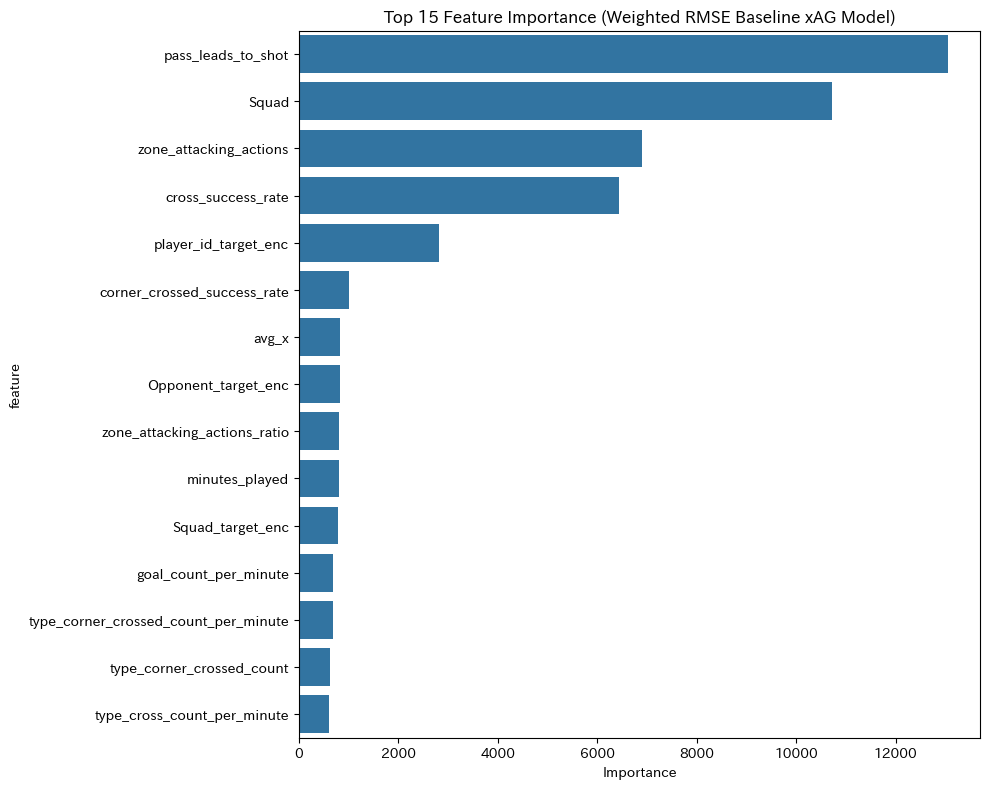

特徴量重要度 Top 10:
                         feature          mean          std
16            pass_leads_to_shot  13043.459394   605.075359
2                          Squad  10716.796969  1945.917277
62        zone_attacking_actions   6899.975698   832.045472
11            cross_success_rate   6442.132380   245.317328
18          player_id_target_enc   2820.251159   620.949536
10   corner_crossed_success_rate    995.497603   266.093621
8                          avg_x    825.669565   214.875033
1            Opponent_target_enc    816.629310   228.454037
63  zone_attacking_actions_ratio    807.469459   143.723436
15                minutes_played    799.706651   202.410225


In [28]:
# 特徴量重要度の平均計算
feature_importance_mean = feature_importance.groupby('feature')['importance'].agg(['mean', 'std']).reset_index()
feature_importance_mean = feature_importance_mean.sort_values('mean', ascending=False)

# 可視化
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance_mean.head(15), x='mean', y='feature')
plt.title('Top 15 Feature Importance (Weighted RMSE Baseline xAG Model)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

print("特徴量重要度 Top 10:")
print(feature_importance_mean.head(10))

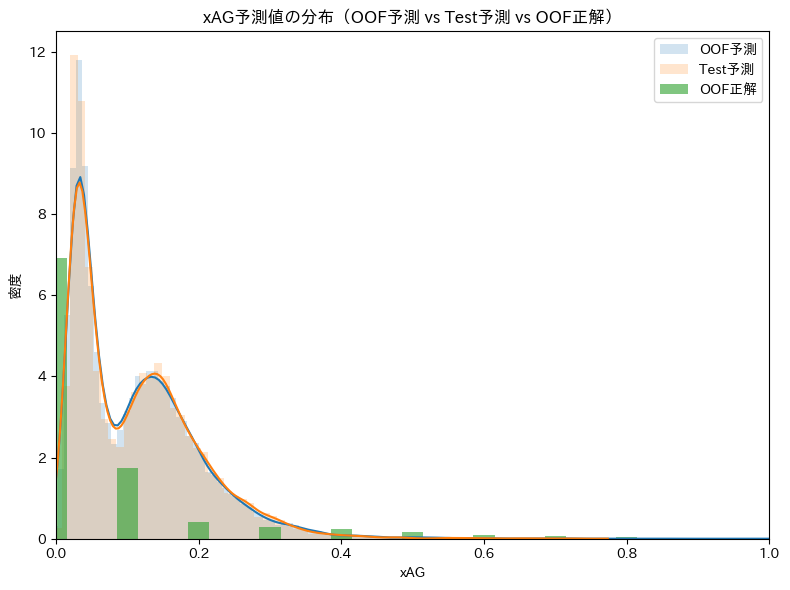

In [29]:
# train, test予測値の分布を可視化
plt.figure(figsize=(8, 6))
sns.histplot(oof_preds, stat='density', kde=True, alpha=0.2, label='OOF予測', linewidth=0)
sns.histplot(test_preds, stat='density', kde=True, alpha=0.2, label='Test予測', linewidth=0)

# train正解値の分布を可視化
vc = y_train.value_counts().sort_index()
heights = vc / vc.sum() / 0.1 # 棒グラフの高さをdensity に合わせる
plt.bar(vc.index, heights, width=0.03, alpha=0.6, label='OOF正解', align='center')

plt.xlabel('xAG')
plt.ylabel('密度')
plt.xlim(0, 1)
plt.title('xAG予測値の分布（OOF予測 vs Test予測 vs OOF正解）')
plt.legend()
plt.tight_layout()
plt.show()

正解が0.0のデータの重み付けが小さいため、全体的に正の値を予想する傾向が見られる。

## 提出ファイル作成

In [32]:
# 提出用ファイルにtestデータに対する予測値を格納
submission_df["xAG"] = test_preds
submission_df.to_csv(f"{base_path}/host_baseline_003_submissions.csv", index=False)